# Traffic Flow Dynamics in Bottleneck

In [1]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import os
import sys
from matplotlib import pyplot as plt
from os import path as osp
from xml.etree import ElementTree as ET

if 'SUMO_HOME' in os.environ:
    tools = osp.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit('Please declare environment variable "SUMO_HOME".')
import sumolib
import traci

sns.set_style('whitegrid')

In [2]:
# Global Parameters
# =========================================
name: str = 'bottleneck'
sumo_binary = 'sumo'
cfg_filepth = '../env/bottleneck/config/bottleneck.sumo.cfg'
warm_up_time: int = 400
total_sim_time: int = 4000

In [3]:
induction_loop_df = pd.DataFrame(
    columns=['id', 'flow', 'occupancy', 'speed', 'harmonic_mean_speed', 'length', 'seed'],
)
for seed in [23, 42, 66, 125, 250, 114, 514]:
    sumo_cmd = [
        sumo_binary, '-c', cfg_filepth, '--start', '--seed', str(seed), '--quit-on-end'
    ]
    traci.start(sumo_cmd, label=name)
    scenario = traci.getConnection(name)

    # Warm up
    # =========================================
    while traci.simulation.getTime() <= warm_up_time:
        traci.simulationStep()

    # Main Loop
    # =========================================
    while True:
        traci.simulationStep()
        if traci.simulation.getTime() > total_sim_time:
            traci.close(scenario)
            break

    # Processing
    detector = ET.parse('../env/bottleneck/data/induction_loop.xml').getroot()
    for i, interval in enumerate(detector.findall('interval')):
        det_id = interval.get('id')
        flow = float(interval.get('flow'))
        occ = float(interval.get('occupancy'))
        speed = float(interval.get('speed'))
        harm_mean_speed = float(interval.get('harmonicMeanSpeed'))
        length = float(interval.get('length'))
        induction_loop_df.loc[i] = [det_id, flow, occ, speed, harm_mean_speed, length, seed]

 Retrying in 1 seconds
***Starting server on port 58427 ***
Loading net-file from '../env/bottleneck/config/bottleneck.net.xml' ... done (3ms).
Loading additional-files from '../env/bottleneck/config/bottleneck.add.xml' ... done (18ms).
Loading done.
Simulation version 1.14.1 started with time: 400.00
Step #4000.20 (4ms ~= 50.00*RT, ~46750.00UPS, TraCI: 1ms, vehicles TOT 3954 ACT 187 BUF 26tep #1300.00 (3ms ~= 66.67*RT, ~62333.33UPS, TraCI: 1ms, vehicles TOT 1028 ACT 187 BUF 16ep #2200.00 (3ms ~= 66.67*RT, ~62000.00UPS, TraCI: 0ms, vehicles TOT 2003 ACT 186 BUF 37p #3100.00 (4ms ~= 50.00*RT, ~46500.00UPS, TraCI: 1ms, vehicles TOT 2978 ACT 186 BUF 58
Simulation ended at time: 4000.20
Reason: TraCI requested termination.
Performance: 
 Duration: 55.09s
 TraCI-Duration: 5.36s
 Real time factor: 65.3489
 UPS: 59562.549917
Vehicles: 
 Inserted: 3954 (Loaded: 4222)
 Running: 187
 Waiting: 268

 Retrying in 1 seconds
***Starting server on port 51009 ***
Loading net-file from '../env/bottlenec

,id,flow,occupancy,speed,harmonic_mean_speed,length,seed,density,cat
0,arrival_0,828.0,35.34,5.03,3.26,5.0,514,253.987730,arrival
1,arrival_1,840.0,35.79,5.03,3.26,5.0,514,257.668712,arrival
2,arrival_2,1104.0,21.15,7.33,7.32,5.0,514,150.819672,arrival
3,arrival_3,1056.0,19.76,7.43,7.42,5.0,514,142.318059,arrival
4,bottleneck_0,1056.0,23.07,6.38,6.36,5.0,514,166.037736,bottleneck


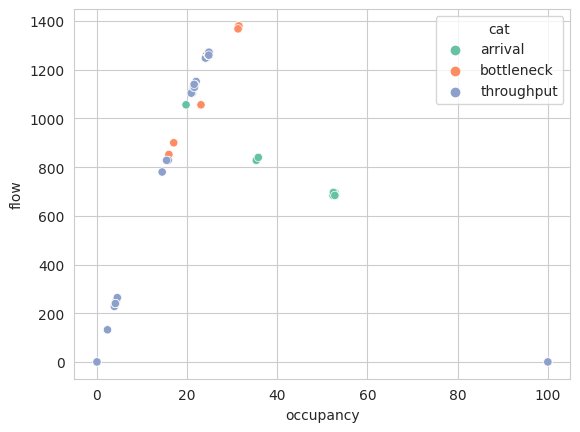

In [6]:
# Experimental
# =========================================
display(induction_loop_df.head(5))
induction_loop_df['density'] = induction_loop_df['flow'] / induction_loop_df['harmonic_mean_speed']
induction_loop_df['cat'] = induction_loop_df['id'].apply(lambda x: x.split('_')[0])

g = sns.scatterplot(
    data=induction_loop_df, x='occupancy', y='flow', hue='cat',
    palette='Set2'
)

In [ ]:
# Aggregation